In [1]:
%%time

## Import Packages 

import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib.mlab import PCA as mlabPCA
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import neighbors
from sklearn.utils import resample
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="sklearn"
    
)



CPU times: user 1.48 s, sys: 414 ms, total: 1.9 s
Wall time: 1.77 s


In [2]:

## Import Files

df = pd.read_csv('weatherAUS.csv')


In [3]:

### Data Cleaning

## Clearing Columns With Large Amount of NA

df = df.drop(['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'], axis=1)
df = df.dropna()

## Making 'RainToday' and 'RainTomorrow' binary

df['RainToday'] = [1 if b=='Yes' else 0 for b in df.RainToday]
df['RainTomorrow'] = [1 if b=='Yes' else 0 for b in df.RainTomorrow]

## Replace extreme values 

up_quantiles = df.quantile(0.99991)
outliers_high = (df > df.quantile(0.99991))
df[outliers_high] = np.nan
df.fillna(up_quantiles, inplace=True)



In [4]:

## View Cleaned Data

#df.head(10)
#df.dtypes
#df.describe()

# Comparing the Ability of Different Logistic Regression Models to Predicting Rainfall in Australia

Logistic Regression Models allows for regression techniques to be used in classification, resulting in well performing classifiers. Ridge and Lasso regression improve on simple logistic regression, by imposing penalties based on parameter estimates.  To gain more insight into the different types of logistic regression model types, I compared the abilities of all three to predict rainfall in Australia using data from several weather stations.

The dataset consists of 142193 observations of the variables related to the time of the observations, location of the observation, and elements of the weather present during the observation. The variable that the models were made to predict is 'RainTomorrow'. The other variables were used as predictors.

In [5]:
df.head(7)

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.400,22.900,0.600,W,44.000,W,WNW,20.000,24.000,71.000,22.000,1007.700,1007.100,16.900,21.800,0,0.000,0
1,2008-12-02,Albury,7.400,25.100,0.000,WNW,44.000,NNW,WSW,4.000,22.000,44.000,25.000,1010.600,1007.800,17.200,24.300,0,0.000,0
2,2008-12-03,Albury,12.900,25.700,0.000,WSW,46.000,W,WSW,19.000,26.000,38.000,30.000,1007.600,1008.700,21.000,23.200,0,0.000,0
3,2008-12-04,Albury,9.200,28.000,0.000,NE,24.000,SE,E,11.000,9.000,45.000,16.000,1017.600,1012.800,18.100,26.500,0,1.000,0
4,2008-12-05,Albury,17.500,32.300,1.000,W,41.000,ENE,NW,7.000,20.000,82.000,33.000,1010.800,1006.000,17.800,29.700,0,0.200,0
5,2008-12-06,Albury,14.600,29.700,0.200,WNW,56.000,W,W,19.000,24.000,55.000,23.000,1009.200,1005.400,20.600,28.900,0,0.000,0
6,2008-12-07,Albury,14.300,25.000,0.000,W,50.000,SW,W,20.000,24.000,49.000,19.000,1009.600,1008.200,18.100,24.600,0,0.000,0


## Data Exploration

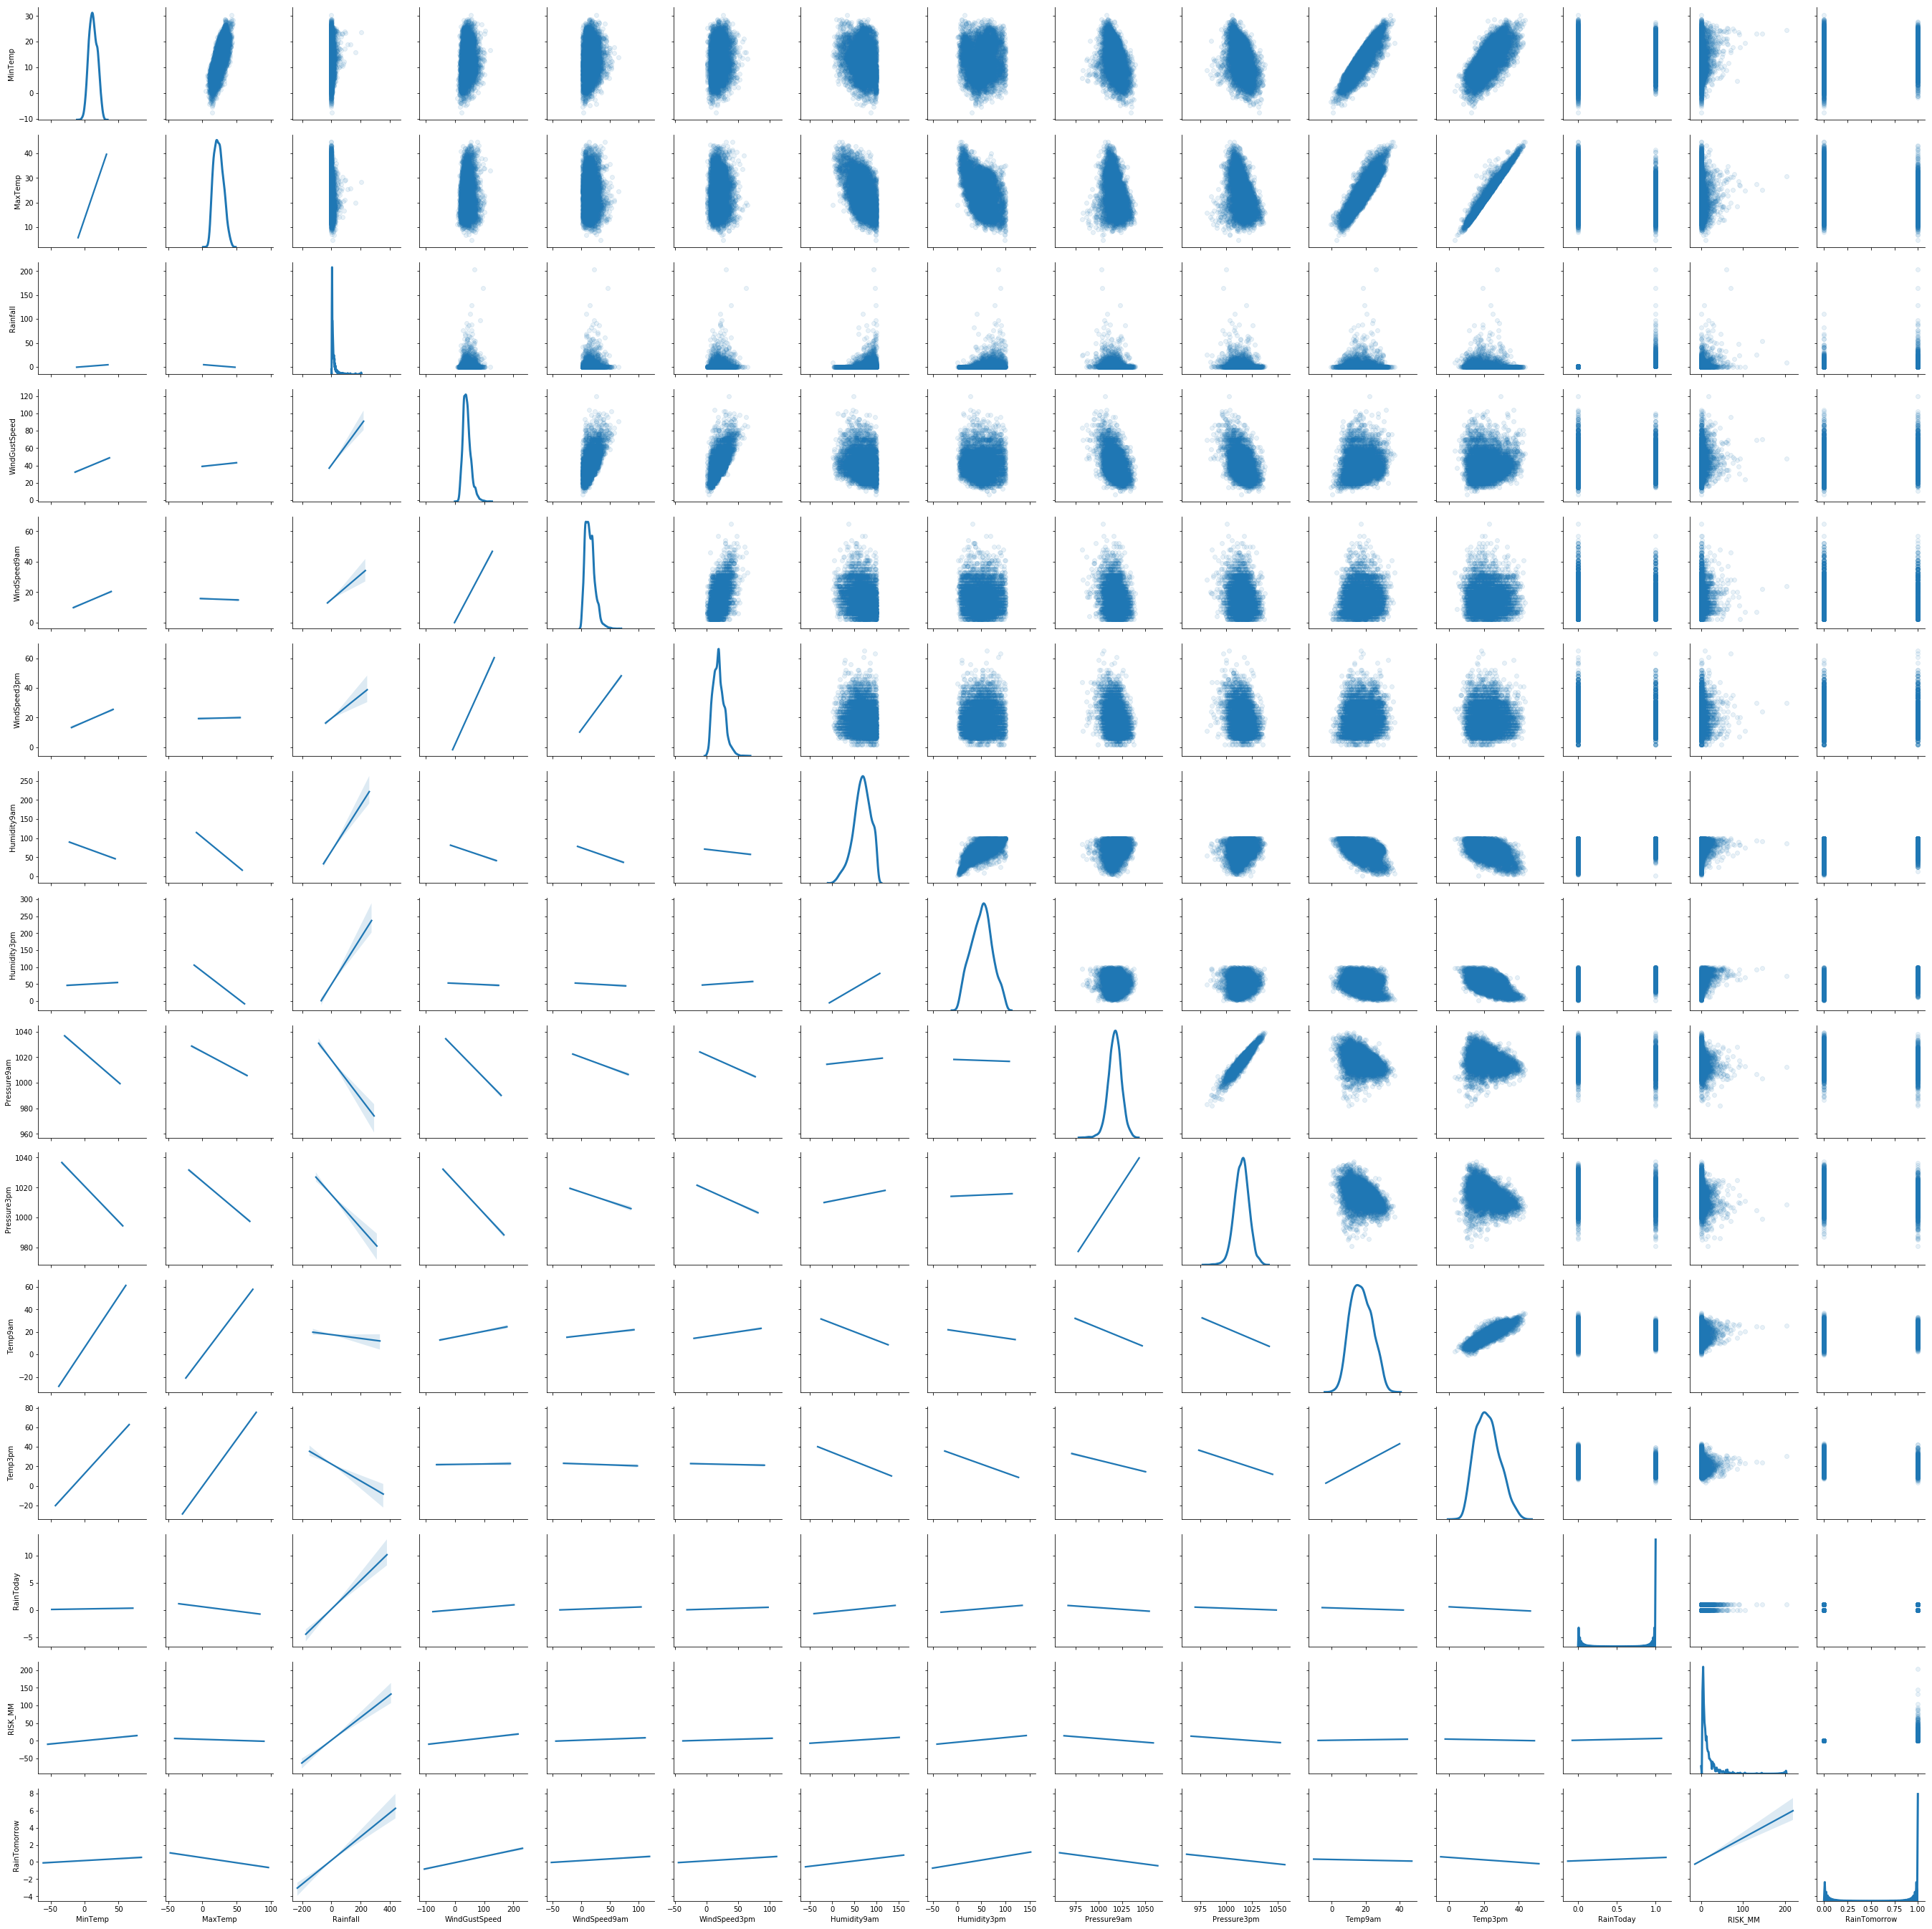

CPU times: user 1min 56s, sys: 12.1 s, total: 2min 8s
Wall time: 1min 18s


In [6]:
%%time

### Creating Scatterplot Matrix with Sample of DataFrame

## Store samples of DataFrame For Visualization

df_sample = df.sample(frac=.05)

## Declare Pairgrid
g = sns.PairGrid(df_sample.dropna(), diag_sharey=False)

## Scatterplot
g.map_upper(plt.scatter, alpha=.1)

## Fit line 
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

## KDE plot
g.map_diag(sns.kdeplot, lw=3)
plt.show()

A small sample of the data was used for the scatterplot matrix to reduce runtimes and make plots more interpretable. Linear relationships exist within the wind, temperature and pressure variables. Many of the continuous variables show signs of binomial distribution. 

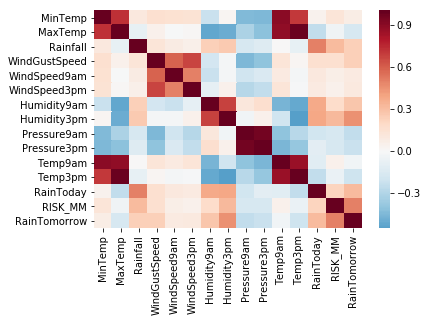

In [7]:

## Visualizing the Correlatedness of the variables

sns.heatmap(df.corr(), cmap='RdBu_r', center=0 )
plt.show()

There's moderate to strong correlatedness within the wind, temperature, humidity, and pressure variables. There's negative correlatedness between: the temperature and the pressure variables; and the temperature and humidity variables.

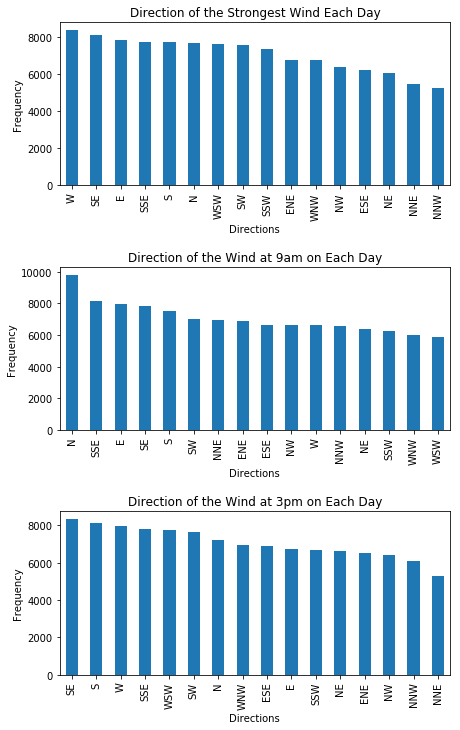

In [8]:

## Barplot of Wind Directions

fig = plt.figure(figsize=(7, 12))
fig.subplots_adjust(hspace=.5)

plt.subplot(3, 1, 1)
ax = df['WindGustDir'].value_counts().plot(kind='bar',
                                    
                                    title="Direction of the Strongest Wind Each Day")
ax.set_xlabel("Directions")
ax.set_ylabel("Frequency")

plt.subplot(3, 1, 2)
ax = df['WindDir9am'].value_counts().plot(kind='bar',
                                    
                                    title="Direction of the Wind at 9am on Each Day")
ax.set_xlabel("Directions")
ax.set_ylabel("Frequency")

plt.subplot(3, 1, 3)

ax = df['WindDir3pm'].value_counts().plot(kind='bar',
                                    
                                    title="Direction of the Wind at 3pm on Each Day")
ax.set_xlabel("Directions")
ax.set_ylabel("Frequency")
plt.show()

In [9]:
print(df['RainTomorrow'].value_counts())

print("\nFraction of \'No\' observations: " + str(df['RainTomorrow'].value_counts().iloc[0] / (df['RainTomorrow'].value_counts().iloc[0] + df['RainTomorrow'].value_counts().iloc[1])))
print("\nFraction of \'Yes\' observations: " + str(df['RainTomorrow'].value_counts().iloc[1] / (df['RainTomorrow'].value_counts().iloc[0] + df['RainTomorrow'].value_counts().iloc[1])))

0    87906
1    25019
Name: RainTomorrow, dtype: int64

Fraction of 'No' observations: 0.7784458711534205

Fraction of 'Yes' observations: 0.2215541288465796


The 'No' class made the majority of 'RainTomorrow' Observations. The strong class imbalance in the outcome will need to be remedied prior to modeling.

## Preparing the Data For Modeling

In [10]:
## Class Balancing by Upsampling Minority Class

# Separate majority and minority classes
df_majority = df[df.RainTomorrow==0]
df_minority = df[df.RainTomorrow==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=87906,    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df = pd.concat([df_majority, df_minority_upsampled])


## Making Date Numeric

df['Date'] = df['Date'].str.replace('-', '')
df = df.apply(pd.to_numeric, errors='ignore')

## Get Dummies so Categorical Variables Can be Used in Regression

df = pd.get_dummies(df)


In [11]:
df['RainTomorrow'].value_counts()

1    87906
0    87906
Name: RainTomorrow, dtype: int64

The class imbalance in the RainTomorrow variable was remedied through upsampling of the minority class (yes) to avoid losing data that may be related to the variance between the features and outcome. Downsampling would produce shorter runtimes but this project doesn't warrant the need to sacrafice data for reduced computational complexity. I made the dates continuous variables by removing the dashes and changing the datatype. This allows for the date of the observations to be used as a feature in the regression model.

## Logistic Regression Classification Modeling

Three logistic regression classifiers were created for comparison using the same data: One without regularization (Vanilla Logistic Regression), one using L2 regularization (Ridge Logistic Regression), and one using L1 regularization (Lasso Logistic Regression). The models were trained and evaluated using the same holdout groups.

In [12]:

## Establishing feature and target variables

x = df.drop(['RainTomorrow'], axis=1)
y = df['RainTomorrow']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20)

### Vanilla Logistic Regression Model

In [13]:
%%time

# Declare a logistic regression classifier
lr = LogisticRegression(C=1e9)
vanilla_lr = lr.fit(x_train, y_train)

CPU times: user 1.87 s, sys: 158 ms, total: 2.03 s
Wall time: 2.09 s


In [14]:
## Accuracy score

print(vanilla_lr.score(x_test, y_test))

## Cross Validation

cv = cross_val_score(vanilla_lr, x, y, cv=10)
print('\n' + str(cv))
print("\n"+str(cv.mean())+"\n")

## Confusion Matrix

vanilla_lr_pred = vanilla_lr.predict(x_test)
print(str(confusion_matrix(y_test, vanilla_lr_pred))+'\n')

## classification_report

print(classification_report(y_test, vanilla_lr_pred))



0.9220203054346898

[0.99670117 0.99562052 0.9947105  0.99391423 0.99726994 0.99186668
 0.9943686  0.99613197 0.99573379 1.        ]

0.9956317396696306

[[16870   757]
 [ 1985 15551]]

              precision    recall  f1-score   support

           0       0.89      0.96      0.92     17627
           1       0.95      0.89      0.92     17536

   micro avg       0.92      0.92      0.92     35163
   macro avg       0.92      0.92      0.92     35163
weighted avg       0.92      0.92      0.92     35163



Logistic Regression without regularization was achieved by setting the coefficient representing the inverse of the regularization strength (C) to an extremely high value. This negated the L2 regularization setting which is the default for the logistic regression function in sklearn. The model has high R-squared, cross validation, and precision scores.

### Ridge Logistic Regression Model

In [15]:
%%time

# Declare a logistic regression classifier
rlr = LogisticRegression(penalty='l2')
ridge_lr = lr.fit(x_train, y_train)

CPU times: user 2.31 s, sys: 181 ms, total: 2.49 s
Wall time: 2.37 s


In [16]:
## Accuracy score

print(ridge_lr.score(x_test, y_test))

## Cross Validation

cv = cross_val_score(ridge_lr, x, y, cv=10)
print('\n' + str(cv))
print("\n"+str(cv.mean())+"\n")

## Confusion Matrix

ridge_lr_pred = ridge_lr.predict(x_test)
print(str(confusion_matrix(y_test, ridge_lr_pred))+'\n')

## classification_report

print(classification_report(y_test, ridge_lr_pred))





0.958962545857862

[0.99613241 0.99510863 0.9959049  0.99601866 0.99601866 0.99220794
 0.99675768 0.99806598 0.99709898 0.97792947]

0.9941243300205287

[[17368   259]
 [ 1184 16352]]

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     17627
           1       0.98      0.93      0.96     17536

   micro avg       0.96      0.96      0.96     35163
   macro avg       0.96      0.96      0.96     35163
weighted avg       0.96      0.96      0.96     35163



The ridge regression classifier was created by removing changes to 'C', leaving the coefficient set at its default value, 1. SkLearn's ridge regression function is primarily used for regression and wasn't used for this project because it didn't return binary outcomes. The ridge regression model reduces overfitting by penalizing large parameters, a sign of multicollinearity. This resulted in better performance than the vanilla logistic regression with lower chances of overfitting.


### Lasso Logistic Regression Model

In [17]:
%%time

# Declare a logistic regression classifier
lr = LogisticRegression(penalty='l1' )
lasso_lr = lr.fit(x_train, y_train)

CPU times: user 52.2 s, sys: 375 ms, total: 52.6 s
Wall time: 52.7 s


In [18]:
%%time

## Accuracy score

print(lasso_lr.score(x_test, y_test))

## Cross Validation

cv = cross_val_score(lasso_lr, x, y, cv=10)
print('\n' + str(cv))
print("\n"+str(cv.mean())+"\n")

## Confusion Matrix

lasso_lr_pred = lasso_lr.predict(x_test)
print(str(confusion_matrix(y_test, lasso_lr_pred))+'\n')

## classification_report

print(classification_report(y_test, lasso_lr_pred))

0.9926058641185337

[0.91002161 0.86759186 0.78079854 0.88402912 0.87538392 0.81446934
 0.9238339  0.91530148 0.86461889 0.96837315]

0.880442180951172

[[17499   128]
 [  132 17404]]

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     17627
           1       0.99      0.99      0.99     17536

   micro avg       0.99      0.99      0.99     35163
   macro avg       0.99      0.99      0.99     35163
weighted avg       0.99      0.99      0.99     35163

CPU times: user 8min 27s, sys: 3.78 s, total: 8min 30s
Wall time: 8min 29s


The lasso regression classifier was created by changing the penalty setting from L2 to L1. SkLearn's lasso regression function is also primarily used for regression and wasn't used for this project because it didn't return binary outcomes. This model demonstrated significantly longer run times than the other two regression models.

This model removes statistical noise by effectively dropping small parameters. In order to keep the lasso model from overfitting I had to remove a very specific amount of high outlier values. I determined this ammount by scrolling through different percentages of values to keep (as opposed to imputing). Keeping too many values resulted in low cross validation scores and a high R-squared. Keeping too few values resulted in overfitting.  Keeping all of the data resulted in low R-squared values and low cross validation scores.

## Analyzing the Compared Effectiveness of Logistic Regression Classifiers

All three models produced high R-squared values. While the lasso regression model produced lower cross validation scores, this was a result of deliberate attempts at curbing overfitting. For this reason, I would argue that  the lasso model has the strongest potential for representing larger and more complex datasets. However, the high performance and relatively low run times makes the ridge regression model the best choice for predicting rain in Australia using the data. This project puts into perspective, the different abilities of logistic regression models as classifiers and allows for more efficient prediction methods in the future.
